# Projeto 2 - Ciência dos Dados

**Eduardo Carvalho Rosa Gonçalves**

**Kamila Addel Wansa**

___
# Classificador automático de sentimento


## Preparando o ambiente no jupyter:

In [1]:
%%capture
#Instalando o tweepy e emoji
!pip install tweepy
!pip install emoji
import pandas as pd
import re
from emoji import UNICODE_EMOJI
import emoji
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
import numpy as np

___
## Autenticando no  Twitter

* Conta: ***[@eduardocrgalin1]***

In [2]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. 
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Etapas do projeto:

### Escolhendo um produto e coletando mensagens


In [3]:
#Produto escolhido:
produto = 'Windows'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua:
lang = 'en'

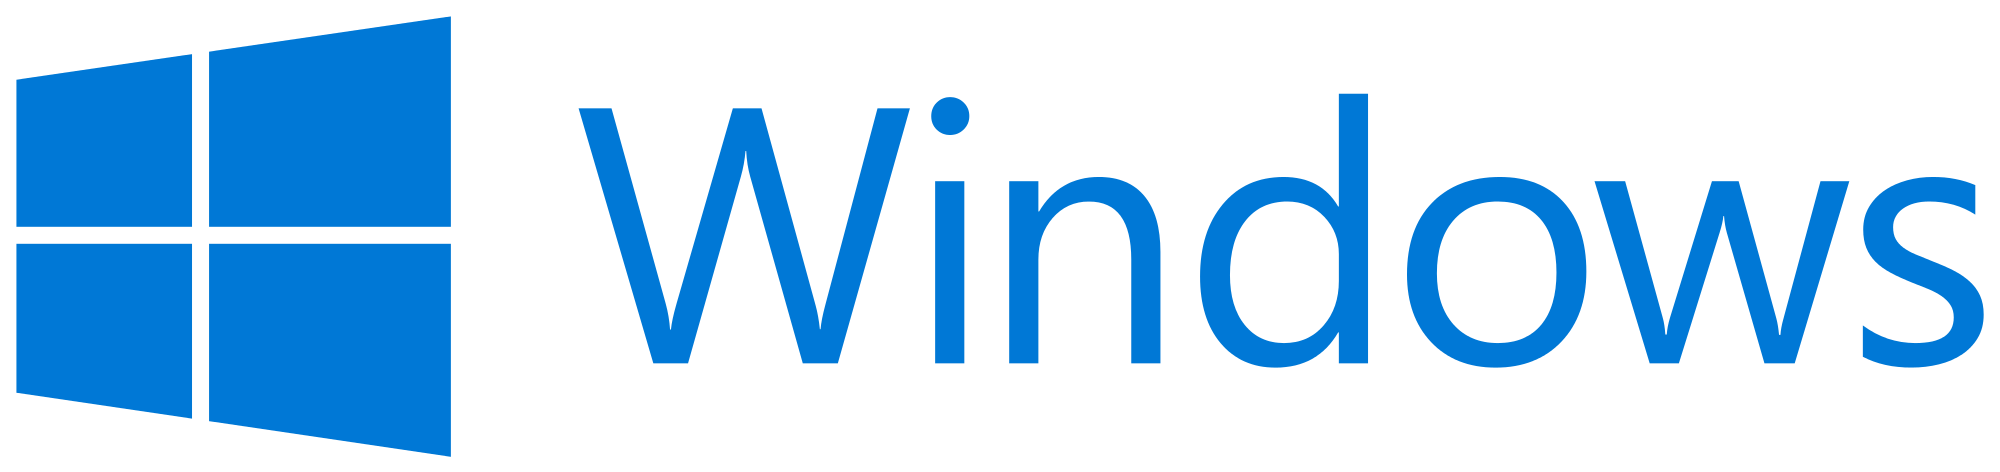

Capturando os dados do twitter:

In [ ]:
#Criando um objeto para a captura
api = tweepy.API(auth)

#Iniciando a captura, para mais detalhes:
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q = produto, lang=lang, tweet_mode="extended").items():
    if msg.full_text.lower()[0] != 'r' and msg.full_text.lower()[1] != 't':
        msgs.append(msg.full_text.lower())
        i += 1
        if i > n:
            break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [ ]:
#Verificando se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abrindo o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #dividindo o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fechando o arquivo
    writer.save()

__________________________
### Montando o Classificador Naive-Bayes

In [4]:
Doc = pd.read_excel('Windows.xlsx', sheet_name = 0)
Doc.head()

,Treinamento,Relevancia
0,@evelynchartres oh that's good to know! i have...,1
1,how to resolve a usb security key is not worki...,1
2,"kumo ind. llc korea\naluminum &amp; u-pvc, win...",0
3,full time: heritage windows 2 - 1 braishfield ...,0
4,@sagaciouszu @aciouvistas @gorydetail it doesn...,1


Limpando os tweets do Treinamento:

In [5]:
limp=[]
for i in Doc.Treinamento:
    a=re.sub('@','',i)
    a=re.sub(':','',a)
    a=re.sub("'",'',a)
    a=re.sub('-','',a)
    a=re.sub('#','',a)
    a=re.sub('"','',a)
    a=re.sub('!','',a)
    a=re.sub(';','',a)
    a=re.sub('\n',' ',a)
    a=re.sub('\t',' ',a)
    a=re.sub('&',' ',a)
    a=a.strip('()')
    a=a.replace('.','')
    a=a.replace('?','')
    a=a.replace(',','')
    limp.append(a)

In [6]:
Doc_limpo = pd.DataFrame()
Doc_limpo['Treinamento']=limp
Doc_limpo['Relevancia']=Doc.Relevancia
Doc_limpo.head()

,Treinamento,Relevancia
0,evelynchartres oh thats good to know i have wi...,1
1,how to resolve a usb security key is not worki...,1
2,kumo ind llc korea aluminum amp upvc windows ...,0
3,full time heritage windows 2 1 braishfield fo...,0
4,sagaciouszu aciouvistas gorydetail it doesnt f...,1


Correção de espaços entre palavras e/ou emojis: 

In [7]:
def is_emoji(s):
    return s in UNICODE_EMOJI

def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

limp_final=[add_space(text) for text in limp]

In [8]:
Doc_limpo = pd.DataFrame()
Doc_limpo['Treinamento']=limp_final
Doc_limpo['Relevancia']=Doc.Relevancia

In [9]:
Doc_limpo.Treinamento=Doc_limpo.Treinamento.str.replace('  ', ' ')
Doc_limpo.head()

,Treinamento,Relevancia
0,evelynchartres oh thats good to know i have wi...,1
1,how to resolve a usb security key is not worki...,1
2,kumo ind llc korea aluminum amp upvc windows d...,0
3,full time heritage windows 2 1 braishfield foo...,0
4,sagaciouszu aciouvistas gorydetail it doesnt f...,1


Separando a data em dois dataframes distintos (Relevantes=1 e Não Relevantes=0):

In [10]:
Doc_0=Doc_limpo[(Doc_limpo.Relevancia==0)]
Doc_1=Doc_limpo[(Doc_limpo.Relevancia==1)]

In [11]:
todas_pal_0=[]

for a in Doc_0.Treinamento:
    a=a.split()
    for palavra in a:
        todas_pal_0.append(palavra)
        
todas_pal_1=[]

for a in Doc_1.Treinamento:
    a=a.split()
    for palavra in a:
        todas_pal_1.append(palavra)

# Teste:

Pegando do Excel o documento "Teste".

In [12]:
Doc = pd.read_excel('Windows.xlsx', sheet_name = 1)
Doc.head()

,Teste,Relevancia
0,bluekeep is a remote windows kernel use-after-...,1
1,"kumo ind. llc korea\naluminum &amp; u-pvc, win...",0
2,"anybody can spot me ""mcsa guide to identity wi...",1
3,thinking about moving to a @windows 10 device?...,1
4,@wocharlog windows wale raped,0


Limpando os tweets do Teste:

In [13]:
limp=[]
for i in Doc.Teste:
    a=re.sub('@','',i)
    a=re.sub(':','',a)
    a=re.sub("'",'',a)
    a=re.sub('-','',a)
    a=re.sub('#','',a)
    a=re.sub('"','',a)
    a=re.sub('!','',a)
    a=re.sub(';','',a)
    a=re.sub('\n',' ',a)
    a=re.sub('\t',' ',a)
    a=re.sub('&',' ',a)
    a=a.strip('()')
    a=a.replace('.','')
    a=a.replace('?','')
    a=a.replace(',','')
    limp.append(a)

In [14]:
Doc_limpo = pd.DataFrame()
Doc_limpo['Teste']=limp
Doc_limpo['Relevancia']=Doc.Relevancia
Doc_limpo.head()

,Teste,Relevancia
0,bluekeep is a remote windows kernel useafterfr...,1
1,kumo ind llc korea aluminum amp upvc windows ...,0
2,anybody can spot me mcsa guide to identity wit...,1
3,thinking about moving to a windows 10 device g...,1
4,wocharlog windows wale raped,0


Correção de espaços entre palavras e/ou emojis: 

In [15]:
def is_emoji(s):
    return s in UNICODE_EMOJI

def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

limp_final=[add_space(text) for text in limp]

In [16]:
Doc_limpo = pd.DataFrame()
Doc_limpo['Teste']=limp_final
Doc_limpo['Relevancia']=Doc.Relevancia

Doc_limpo.Teste=Doc_limpo.Teste.str.replace('  ', ' ')
Doc_limpo.head()

,Teste,Relevancia
0,bluekeep is a remote windows kernel useafterfr...,1
1,kumo ind llc korea aluminum amp upvc windows d...,0
2,anybody can spot me mcsa guide to identity wit...,1
3,thinking about moving to a windows 10 device g...,1
4,wocharlog windows wale raped,0


Classificador utilizando o classificador Naive-Bayes e utilizando o smoothing de Laplace:

In [17]:
total = len(Doc_limpo[(Doc_limpo.Relevancia==0)]) + len(Doc_limpo[(Doc_limpo.Relevancia==1)])
P0= len(Doc_limpo[(Doc_limpo.Relevancia==0)])/total
P1= len(Doc_limpo[(Doc_limpo.Relevancia==1)])/total

In [44]:
lista_tot=[]
for a in Doc_limpo.Teste:
    lista_pal=a.split(' ')
    lista_tot.append(lista_pal)

d = 10
alfa= 1

lista_zero=[]
lista_um=[]
lista_comp=[]

for a in lista_tot:
    zero=1
    um=1
    for palavra in a:
        z=0
        z0=0
        u=0
        u0=0
        if palavra in todas_pal_0:
            for palavra in todas_pal_0:
                while z < len(todas_pal_0):
                    if palavra==todas_pal_0[z]:
                        z0+=1
                    z+=1
                    
            zero*=((z0)+alfa)/((len(todas_pal_0))+alfa*d)
        if palavra not in todas_pal_0:
            zero*=(alfa)/((len(todas_pal_0))+alfa*d)
        if palavra in todas_pal_1:
            for palavra in todas_pal_1:
                while u < len(todas_pal_1):
                    if palavra==todas_pal_1[z]:
                        u0+=1
                    u+=1
            um*=((u0)+alfa)/((len(todas_pal_1))+alfa*d)
        if palavra not in todas_pal_1:
            um*=(alfa)/((len(todas_pal_1))+alfa*d)
    lista_zero.append(zero*P0)
    lista_um.append(um*P1)

Doc_limpo['Probabilidade zero']=lista_zero
Doc_limpo['Probabilidade um']=lista_um

i=0
while i<len(lista_zero):
    if lista_zero[i]<lista_um[i]:
        lista_comp.append(1)
    else:
        lista_comp.append(0)
    i+=1

Doc_limpo['Relevancia Computador']=lista_comp

In [45]:
Doc_limpo.head()

,Teste,Relevancia,Probabilidade zero,Probabilidade um,Relevancia Computador
0,bluekeep is a remote windows kernel useafterfr...,1,4.731537e-84,2.259432e-82,1
1,kumo ind llc korea aluminum amp upvc windows d...,0,2.392967e-112,6.175752e-139,0
2,anybody can spot me mcsa guide to identity wit...,1,4.794826e-75,3.130993e-68,1
3,thinking about moving to a windows 10 device g...,1,1.703353e-82,3.628100e-61,1
4,wocharlog windows wale raped,0,1.120980e-14,3.391681e-15,0


In [46]:
Doc_final=Doc_limpo

___
### Verificando a performance

Testando o classificador com a base de dados.

In [47]:
i=0
num_acertos=0

while i<len(Doc_final.Relevancia):
    if Doc_final.Relevancia[i]==Doc_final['Relevancia Computador'][i]:
        num_acertos+=1
    i+=1

porcentagem_de_acertos= num_acertos/len(Doc_final.Relevancia)
print(porcentagem_de_acertos*100)
    

86.5


Resultados:

In [48]:
i=0
verd_pos=0
pos_tot=0

while i<len(Doc_final.Relevancia):
    if Doc_final.Relevancia[i]==1 and Doc_final['Relevancia Computador'][i]==1:
        verd_pos+=1
    i+=1

for a in range(len(Doc_final.Relevancia)):
    if Doc_final.Relevancia[a]==1:
        pos_tot+=1
        
verdadeiros_positivos= verd_pos/pos_tot

falsos_positivos= (1 - verdadeiros_positivos)


i=0
verd_neg=0
neg_tot=0

while i<len(Doc_final.Relevancia):
    if Doc_final.Relevancia[i]==0 and Doc_final['Relevancia Computador'][i]==0:
        verd_neg+=1
    i+=1

for a in range(len(Doc_final.Relevancia)):
    if Doc_final.Relevancia[a]==0:
        neg_tot+=1
        
verdadeiros_negativos= verd_neg/neg_tot

falsos_negativos= (1 - verdadeiros_negativos)

print('Dentre os dados relevantes, {}% foram corretamente identificados como relevantes pelo algoritmo.'.format(round(verdadeiros_negativos*100)))
print('Dentre os dados relevantes, {}% foram incorretamente identificados como irrelevantes pelo algoritmo.'.format(round(falsos_negativos*100)))
print('Dentre os dados irrelevantes, {}% foram corretamente identificados como irrelevantes pelo algoritmo.'.format(round(verdadeiros_positivos*100)))
print('Dentre os dados irrelevantes, {}% foram incorretamente identificados como relevantes pelo algoritmo.'.format(round(falsos_positivos*100)))


Dentre os dados relevantes, 94% foram corretamente identificados como relevantes pelo algoritmo.
Dentre os dados relevantes, 6% foram incorretamente identificados como irrelevantes pelo algoritmo.
Dentre os dados irrelevantes, 78% foram corretamente identificados como irrelevantes pelo algoritmo.
Dentre os dados irrelevantes, 22% foram incorretamente identificados como relevantes pelo algoritmo.


___
# Concluindo

Podemos concluir que a performance do classificador automático de sentimento foi satifatória, com 20% de falsos negativos e 7% de falsos positivos identificado pelo algorítimo. Por outro lado, como houve de fato essas porcentagens de erro, pode-se concluir que aprimoramentos poderiam ter sido implementados. Dentre eles, criar um treinamento com mais de 300 tweets de forma a torná-lo mais eficiente, tirar os "https://" (por meio da função replace), colocar todos os caracteres em minúsculo (utilizando a função .lower()) ou tornar derivações de uma mesma palavra equivalente a ela (importando um dicionário externo de semelhanças entre palavras por exemplo), além disso ter criado categorias intermediárias de relevância baseadas na probabilidade também poderia ter sido bastante interessante. Outra questão que o nosso classificador não consegue identificar de forma eficaz é a presença de ironias ou sarcasmos, de forma que piadas por exemplo, não conseguiram ser corretamente identificadas de modo que a porcentagem de falsos positivos ou negativos fossem aumentadas.

Fora do contexto do projeto, conseguimos pensar em diversas outras aplicabilidades do Naïve Bayes como por exemplo dentro da área da medicina com a probabilidade de doenças e a sua relação com a eficácia dos exames realizados, ou mesmo dentro da área da genética com descrição de diferentes probabilidades relacionadas a ela. Também no cenário tecnológico, é possível criar um sistema de recomendação com técnicas de *Machine Learning*, que ajuda alguma plataforma a satisfazer seus usuários.

Por fim, caso utilizasse-mos o próprio classificador para alimentar a base de treinamento automaticamente, criarimos algo com viés, já que as palavras "novas" que seriam classificadas seriam as mesmas já analisadas pelo treinamento, de modo que levaríamos o mecanismo a convergir para algo que ele já antes convergia.

## Aperfeiçoamento:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis ✅ 
* Corrigir separação de espaços entre palavras e emojis ou emojis e emojis ✅ 
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação ✅ 
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento ✅ 
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto ✅ 
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa) ✅ 

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**